# Geoquip Marine Task


<center><img src="geoquip-marine-logo.png"></center>

The goal of this work is to determine from the cone-penetrometer testing (CPT) dataset which unmarked ('-') entries might be close to a sample of a problematic material. If a row is within 20 cm of that material, the *Near Material* mark is set to 'y'. Some samples contain none of that material, and so rows within 20 cm of those samples are marked with 'n'. The '-' rows may or may not contain this material as no samples were taken near these locations. 

*There is also no guarantee that the marked rows contain the material, but being close to a known sample raises the chances that they are*.

We will predict whether the '-' entries are more likely to be close to a problematic material. We will explain and justify all the steps involved in this task, detailing the methods and relevant insights.

#### Premise:  
Since there is no guarantee that each 'y' row contains the problematic material with absolute certainty, we account for this fact by encoding the label into a probability, with values sampled uniformly at random in the interval [0.9,1]. The 'n' labels are converted to 0 numerical values. We will then predict the probability that '-' rows are within 20 cm to a problematic material and do not perform a classification task.

## Loading the Dataset

We start by importing the libraries that will be used to load and process the dataset.

In [1]:
# import libraries to process data
import numpy as np
import scipy as sp
import pandas as pd

# plotting 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

# operative system
import os 


%matplotlib inline

Create directory 'Figures' that stores the plots generated in the notebook.

In [2]:
directory = 'Figures'

# it provides functions for interacting with the operating system
# and creates a directory with all the plots created in the notebook
os.makedirs(directory,exist_ok=True) 

In [3]:
# if openyxl is not installed type in a Linux terminal 'pip install openpyxl'
df = pd.read_excel('task.xlsx',engine='openpyxl')

# peek first 5 entries of the dataset
df.head() 

,Location,z [m],qc [MPa],fs [MPa],u2 [MPa],qnet [MPa],Bq [-],Rf [%],Ic [-],Near Material
0,1,0.00,1.000000e-09,1.000000e-09,0.000000,1.000000e-09,0.000000,100.000000,0.000000,-
1,1,0.02,6.580774e-01,3.884547e-03,0.001524,6.580762e-01,0.002017,0.589946,1.784329,-
2,1,0.04,6.363243e-01,4.051874e-03,0.008934,6.377935e-01,0.013393,0.634535,1.796690,-
3,1,0.06,7.453002e-01,4.307320e-03,0.017934,7.486372e-01,0.023170,0.574475,1.772931,-
4,1,0.08,7.574394e-01,6.100923e-03,0.015319,7.597404e-01,0.019131,0.801415,1.831574,-


In [4]:
# change name of columns to delete unit of measurements, which are consistent
df.columns = ['Location','z','qc','fs','u2','qnet','Bq','Rf','lc','Near_Material']

The dataset contains nine features:
 
 
- Location: Location key for borehole


- z: Metres below the sea floor


- qc: Tip resistance in Mega Pascals


- fs:  Sleeve friction in Mega Pascals


- u2:  Pore water pressure in Mega Pascals.


- qnet: Total cone resistance in Mega Pascals.


- Bq: Normalised Pore Pressure ratio


- Rf: Friction Ratio


- lc: Soil behaviour type index

The table below shows entries with null values. Given the low proportion of missing entries, we can replace them by taking the mean per *Near_material* class. We will postpone this process after detecting potential outliers, as they bias the mean. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34705 entries, 0 to 34704
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       34705 non-null  int64  
 1   z              34705 non-null  float64
 2   qc             34698 non-null  float64
 3   fs             32357 non-null  float64
 4   u2             34698 non-null  float64
 5   qnet           34698 non-null  float64
 6   Bq             34698 non-null  float64
 7   Rf             32357 non-null  float64
 8   lc             31981 non-null  float64
 9   Near_Material  34705 non-null  object 
dtypes: float64(8), int64(1), object(1)
memory usage: 2.6+ MB


Before estimating the probability for the unmarked data, we conduct an exploratory data analysis to uncover possible insights.

## Exploratory Data Analysis

We summarize descriptive statistics of each feature in the table below.

In [6]:
df.describe()

,Location,z,qc,fs,u2,qnet,Bq,Rf,lc
count,34705.000000,34705.000000,3.469800e+04,32357.000000,34698.000000,34698.000000,34698.000000,32357.000000,31981.000000
mean,9.027143,29.563407,2.356084e+01,0.317661,-0.014843,22.992060,-0.008341,1.918727,2.034342
std,5.161903,19.151761,1.869839e+01,0.287801,0.564318,18.729554,0.098494,2.565078,0.638437
min,1.000000,0.000000,1.000000e-09,-0.005938,-0.757732,-0.651000,-1.122546,-0.897363,0.000000
25%,4.000000,13.300000,9.666361e+00,0.087036,-0.497979,9.183222,-0.056878,0.529568,1.436664
50%,9.000000,27.800000,1.838981e+01,0.210488,0.040255,17.451812,-0.004026,0.894370,1.953743
75%,14.000000,42.520000,3.313505e+01,0.527943,0.201416,32.786563,0.000451,3.119699,2.608701
max,18.000000,72.680000,1.159382e+02,1.580817,2.914160,115.443393,1.261490,100.000000,7.889604


At first sight, we note that most of the features have a maximum value far away from the correspondng mean. We can confirm this observation by displaying the distribution and boxplots of those features per *Near_material* class.

In [7]:
# specify filter to select only entries of a specific class
cond_y = df['Near_Material'].str.contains('y')
cond_n = df['Near_Material'].str.contains('n')
cond_0 = df['Near_Material'].str.contains('-')

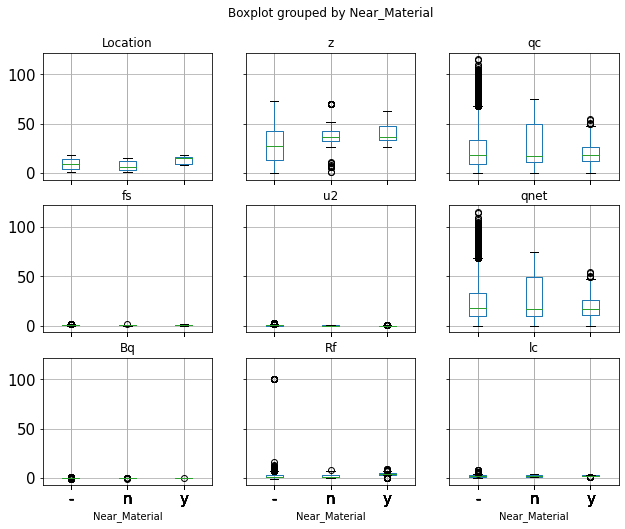

In [8]:
boxplot = df.boxplot(grid=True,fontsize=15,column=list(df.columns[:-1]),by ='Near_Material',figsize = (10,8))
plt.savefig(directory +'/boxplot.png')

From the boxplots above we make the following observations:

- *Location* is the only feature that does not contain outliers.


- The distributions of *qnet* and *qc* are left skewed for the unmarked data, while for marked entries are less skewed. Domain knowledge about the expected distributions of those features might help assess whether the outliers are due to error measurements. 


- The *z* feature for 'n' entries has most of the outliers on the left tail of the distribution. This might be explained by the fact that for locations supposedly far from the problematic material the penetration of the borehole is not as deep as for the 'y' entries.


We show below the boxplot of *Rf* (without the maximum value), *lc*, *Bq*, and *u2* to detect other potential outliers.

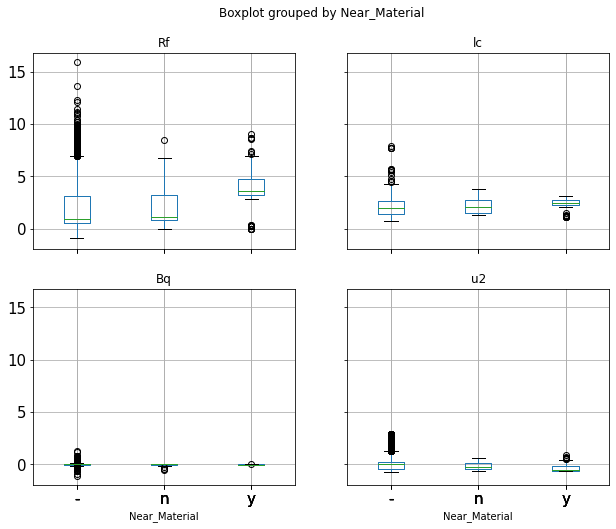

In [9]:
boxplot = df[df['Rf'] < 80].boxplot(grid=True,fontsize=15,column= ['Rf','lc','Bq','u2'],by ='Near_Material',figsize = (10,8))
plt.savefig(directory + '/boxplot_other_feats.png')

We note more clearly that the distribution of *Rf* is left skewed. According to this [article](https://aip.scitation.org/doi/abs/10.1063/1.5028062) published in the AIP Conference Proceedings, we can see from table 1 that usual values of the friction ratio range from 1.2% to 7%. Values above 10% might be due to measurement errors or indicate clayey materials. Another exception is buried wood, which can result from *Rf* values much greater than 20%. The distributions for 'n' and 'y' entries are shifted. This might help classify the unmarked data.

Similarly, all other features display many outliers for the unmarked data and few ones for the marked entries. The distributions for 'n' and 'y' data do not differ significantly.

We proceed with the detection of the outliers and the imputation of the missing values. We follow the 1.5 interquartile (IQR) rule:

- Find the quartile, and interquartile regions.


- Calculate 1.5*IQR below the first quartile and check for low outliers.


- Calculate 1.5*IQR above the third quartile and check for outliers.



In [10]:
for cond in (cond_y,cond_n,cond_0):
    
    # finding the 1st quartile for all features (except Location and Near_Material)
    qr1 = df[cond][df.columns[1:-1]].quantile(0.25)
    
    # finding the 3rd quartile for all features (except Location and Near_Material)
    qr3 = df[cond][df.columns[1:-1]].quantile(0.75)
    
    # finding the iqr region
    iqr = qr3-qr1
 
    # finding lower and upper whiskers
    qr1 - (1.5*iqr)
    qr3 + (1.5*iqr)
    
    # compute the mean for each feature excluding outliers per 'Near_Material' class
    col_mean = df[cond][(df[cond] < qr3) & (df[cond] > qr1)].mean()
    
    # fill null values with col_mean
    df[cond] = df[cond].fillna(col_mean)

We now examine the correlation among features. To this aim, we plot a Heatmap with relative correlation coefficients.

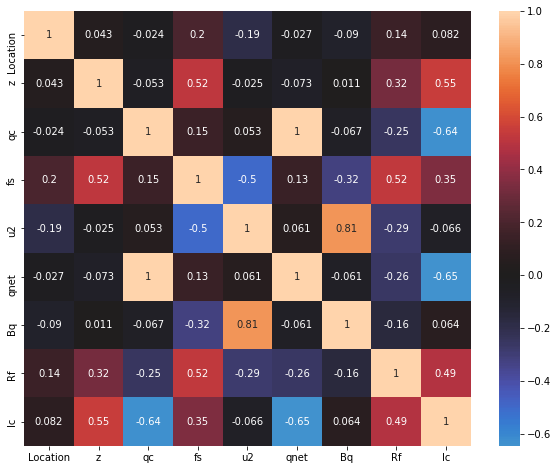

In [11]:
df_corr = df.corr()

plt.figure(figsize = (10,8))
sns.heatmap(df_corr, center = 0,annot=True)
plt.savefig(directory + '/heatmap.png')
plt.show()

We observe that the most correlated features are (*qc*,*qnet*): 1 and (*Bq*,*u2*): 0.81.

The features *qc* and *qnet* have similar values. In the Glossary of the paper [Guide to
Cone Penetration Testing for Geotechnical Engineering](https://www.g-i.co.nz/wp-content/uploads/greggs-cpt-guide-6th-2015.pdf), we read that *qc* is defined as the force acting on the cone, divided by the projected area of the
cone. The net cone resistance *qn* is the corrected cone resistance minus the vertical total stress:

$$ qn = qc + u_2(1- a) – \sigma_{vo}, \quad u_2(1-a): \textit{pore power effect}, \; \sigma_{vo}:\textit{vertical total stress}.$$


If *qn* is equal to *qnet*, then there is a deterministic relationship between the two variables. Since *qc* and *qnet* convey the same information, we decide to drop *qc* from the dataset.

In [12]:
# delete feature qc
df = df.drop('qc',axis=1)

After imputing the missing entries, we show the distribution plots for the marked classes.

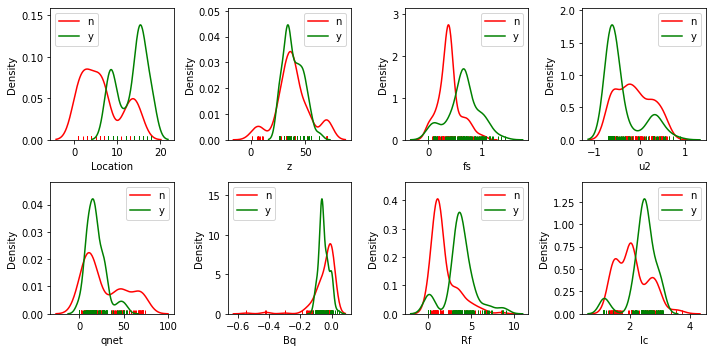

In [13]:
fig, axes = plt.subplots(nrows = 2, ncols = 4,figsize = (10,5))     # axes is 2d array (2x4)
axes = axes.flatten()                                               # Convert axes to 1d array of length 8

for ax, col in zip(axes, df.columns[:-1]):
    sns.distplot(df[cond_n][col], ax = ax,label = 'n',color='r', rug=True, hist=False)
    sns.distplot(df[cond_y][col], ax = ax,label = 'y',color = 'g', rug=True, hist=False)
    ax.legend()
    plt.tight_layout()

plt.savefig(directory +'/distplot.png')    

We observe that the discriminant features that can be exploited to predict probabilities accurately are *Location*, *Rf* and *fs*.

Finally, it is important to determine the ratio between unmarked and marked entries This is visually showed in the barplots below.

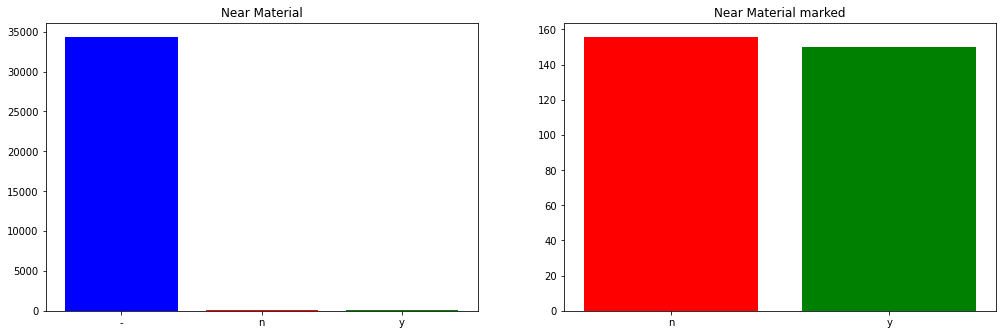

n° unmarked entries: 34399, marked entries: 306.


In [14]:
colors = ["blue","red","green"]
colors_marked = ["red","green"]


series = df["Near_Material"].value_counts()

sq = series.sort_index()
sq_labelled = series[1:].sort_index()

fig,ax = plt.subplots(1, 2)
ax[0] = fig.add_axes([0,0,1,1])   # x0,y0,width,height
ax[0].bar(sq.index,sq.values, color = colors)
ax[0].set_title("Near Material")

ax[1] = fig.add_axes([1.2,0,1,1])
ax[1].bar(sq_labelled.index,sq_labelled.values, color = colors_marked)
ax[1].set_title("Near Material marked")
fig.savefig(directory + '/barplot_class.png')
plt.show()


print(f'n° unmarked entries: {len(df[cond_0])}, marked entries: {len(df[cond_y | cond_n])}.')

The number of the unmarked entries is much higher than the marked ones. In contrast, marked entries are balanced and can be used to train a machine learning model without the risk of overfitting on one mark (in practice, over 0 or [0.9,1]).

**Machine learning models must be able to predict for the unmarked data by exploiting features distributed similarly for marked data or with features having a linear dependence on the class membership.**

## Machine Learning Models

Since we have decided to encode the categorical classes (marks) into numerical values, we will train soft machine learning classifiers, which explicitly estimate the probability of being within 20 cm of a problematic material. We list below some popular soft classifiers that will be trained, and describe relative pros and cons:

- SVR (Support Vector Regressor):
   - Pros: Performs well when the number of features are high, robust to outliers and its implementation is easy. 
   - Cons: Selecting appropriate hyper-parameters and kernel function is tricky, not suitable for large data sets.
   
   
- KNN (K Nearest Neighbors) Regressor: 
    - Pros: Simple to implement and does not require assumption about data (e.g. independence of features).
    - Cons: Sensitive to outliers and can’t deal well with missing values.


- Random Forest Regressor: 
    - Pros: Robust to outliers with no need of scaling, works well with non-linear data and has lower risk of overfitting. 
    - Cons: Features need to have some predictive power, predictions of the trees need to be uncorrelated and might be tough to tune the different hyper-parameters.


In our context, the training dataset is relatively small, contains outliers, and features might have
non-linear dependence on the marks (data). We decide to use a Random Forest Regressor as the most suitable model for the next prediction task and evaluation of confidence intervals.

### Random Forest and Feature Importance

The Random Forest is based on **bagging**, which is an ensemble algorithm that fits multiple models (trees) on different subsets of a training dataset, then combines the predictions from all models. Random forest is an extension of bagging that also randomly selects subsets of features used for constructing the trees at each iteration. Each tree in the ensemble relies on samples drawn from the training set with replacement, called the **bootstrap sample**. 

Random Forests also provide two methods to evaluate **feature importances**: mean decrease impurity and mean decrease accuracy.

- Mean decrease impurity (MDI): Every node in a regression tree is designed to split the dataset into two children, so that similar predicted values end up in the same child node. The splitting criterion is usually based on the variance reduction computed by mean squared error (MSE) or mean absolute error (MAE). When training a tree, the importance of a feature can be computed by its variance reduction from the parent node to the two children nodes. The importance for the Forest is given by averaging the variance reduction of all trees. We can also compute the standard deviation of the variance reduction among all trees to see how confident we can be about the result. More information about the implementation of the method is provided in the [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

There are a few things to bear in mind when using this method. Firstly, **MDI is biased towards high-cardinality features**, which contain many different unique values. Secondly, when the dataset has correlated features, then any of these correlated features can be used as the predictor, with no concrete preference of one over the others. In our context, the *Location* feature does not have high correlation with other features, but has many unique values (from 1 to 18). We can overcome this drawback by computing the feature importance with the mean decrease accuracy, which does not suffer from that bias. 

- Mean decrease accuracy (MDA): The general idea is to permute the values of each feature and measure how much the permutation decreases the accuracy of the model. Clearly, for unimportant variables, the permutation should have little to no effect on model accuracy, while permuting important variables should significantly decrease it. More information about the implementation of the method is provided in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html).

We first import the relevant machine learning libraries used for training, tuning hyper-parameters, and compute performance metrics.

In [15]:
from sklearn.model_selection import train_test_split                             # Split in training and test set
from sklearn.ensemble import RandomForestRegressor                               # Random Forest Regressor
from sklearn.neighbors import KNeighborsRegressor                                # KNN Regressor
from sklearn.svm import SVR                                                      # Support Vector Regressor  

# tune hyper-parameters of Random Forest Regressor
from sklearn.model_selection import GridSearchCV                                 

# performance metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

# feature importance computed with mean decrease accuracy
from sklearn.inspection import permutation_importance

As specified in the premise, we now convert the 'y' marks to values ranging in [0.9,1] and the 'n' marks to 0. 

Given the test (unmarked) data, we have to ensure that the Random Forest Regressor will predict always values within 0 and 1. This is not a problem, as the range of predictions a Random Forest can make is bound by the highest and lowest mark values in the training data. In fact, the Random Forest Regressor will always predict for test data an average of those values seen previously. 

In [16]:
def encode_to_numeric(row):
    if row['Near_Material'] == 'y':
        # set seed to reproduce results
        np.random.seed(row.name)
        return np.random.uniform(low=0.9, high=1.0, size=1)[0]
    elif row['Near_Material'] == 'n':
        return 0
    
    return -1

In [17]:
df2 = df.copy()
df2['Near_Material'] = df2.apply(encode_to_numeric,axis=1)
training_data = df2[(df2['Near_Material'] >= 0) & (df2['Near_Material'] <= 1)] 

X = training_data.drop("Near_Material", axis = 1,inplace=False)
y = training_data["Near_Material"]

The training process of the previous machine learning models involves different steps:

-  Split the original dataset with marked entries into training and test set.


-  If a machine learning model has many hyper-parameters to be tuned, split the training set and perform cross-validation.


- Fit the model to the training data.


- Predict the classes/values in the test set with the trained model.


- Compare the actual classes/values of test set with the predicted ones using a performance metric, which we aim to minimise.


We will follow all those steps except for the second one. We have observed that the hyper-parameters tuned by the 
*GridSearchCV* module do not impact significantly the performance metrics of the Random Forest. For the interested reader, we refer to the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) for more details about this module.

Another pre-processing step that is usually performed before training a model is scaling the variables. We skip this step as we are eventually interested in the Random Forest Regressor, which does not require feature scaling. 

In [18]:
# parameters for GridSearchCV
param_grid = { 
    'n_estimators': [10,20,50,100],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [5,6,7,8],
    'criterion': ['mse', 'mae'],
    'random_state' : [5,10,20,30]
}

In [19]:
# we take 20% of the test size as the training dataset is relatively small
# set random_state to reproduce the result
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# For RandomForestRegressor():
# default parameters are n_estimators = 100, criterion = mse, max_features = 1, min_samples_split=2, min_samples_leaf=1  
# set the parameter random_state to any value to see that the results are similar 
# to that ones shown in the presentation

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# the default RandomForestRegressor yields slighly worse performance than grid_rf
# feature importances for grid_rf show higher std, so we have preferred the default one

#grid_rf = GridSearchCV(rf,param_grid,cv=5,n_jobs=-1) # use 5-fold cross validation
#grid_rf.fit(X_train, y_train)
#pred_rf = grid_rf.predict(X_test)

knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)

svr = SVR()
svr.fit(X_train, y_train)
pred_svr = svr.predict(X_test)

In [21]:
# print best parameter of Random Forest Regressor after running GridSearchCV
#print(grid_rf.best_params_) 

We can evaluate the performance of the model with different performance metrics. Here we list the most popular ones:

- Mean Squared Error (MSE): average of the squares of the errors. It incorporates both the variance of the estimator and its bias. MSE has the same units of measurement as the square of the quantity being estimated. Due to its formulation, MSE penalizes larger errors more severely.


- Root Mean squared error (RMSE): squared root of the MSE, which has the same units as the quantity being estimated. 


- Mean absolute error (MAE): mean of absolute differences between actual and predicted values. It is measured in the same units as the original data, and is always lower than the root mean squared error.


Overall, MSE and RMSE give more importance to highest errors and are more sensitive to outliers, whereas MAE is more robust to outliers. RMSE and MSE are better in terms of reflecting performance when dealing with large error values, differently from MAE.


We show in the barplot below the scores for the different models that have been trained. We remark that the best model minimises all the performance metrics.

In [22]:
print('Metrics for Random Forest Regressor')
print('Mean Squared Error (MSE):', MSE(y_test, pred_rf))
print('Root Mean Squared Error (RMSE):', np.sqrt(MSE(y_test, pred_rf)))
print('Mean Absolute Error (MAE):', MAE(y_test, pred_rf))
print()
print('Metrics for KNN Regressor')
print('Mean Squared Error (MSE):', MSE(y_test, pred_knn))
print('Root Mean Squared Error (RMSE):', np.sqrt(MSE(y_test, pred_knn)))
print('Mean Absolute Error (MAE):', MAE(y_test, pred_knn))
print()
print('Metrics for SV Regressor')
print('Mean Squared Error (MSE):', MSE(y_test, pred_svr))
print('Root Mean Squared Error (RMSE):', np.sqrt(MSE(y_test, pred_svr)))
print('Mean Absolute Error (MAE):', MAE(y_test, pred_svr))

Metrics for Random Forest Regressor
Mean Squared Error (MSE): 0.004476416789098939
Root Mean Squared Error (RMSE): 0.06690602954217907
Mean Absolute Error (MAE): 0.029766087464943154

Metrics for KNN Regressor
Mean Squared Error (MSE): 0.012140336367441487
Root Mean Squared Error (RMSE): 0.11018319457812742
Mean Absolute Error (MAE): 0.043188227150552455

Metrics for SV Regressor
Mean Squared Error (MSE): 0.06493113157644545
Root Mean Squared Error (RMSE): 0.2548158777950178
Mean Absolute Error (MAE): 0.19805766823847587


In [23]:
df_score = pd.DataFrame({'RF':[MSE(y_test, pred_rf),np.sqrt(MSE(y_test, pred_rf)),MAE(y_test, pred_rf)],\
                         'KNN':[MSE(y_test, pred_knn),np.sqrt(MSE(y_test, pred_knn)),MAE(y_test, pred_knn)],\
                         'SVR': [MSE(y_test, pred_svr),np.sqrt(MSE(y_test, pred_svr)),MAE(y_test, pred_svr)]})
df_score.index = ['MSE','RMSE','MAE']

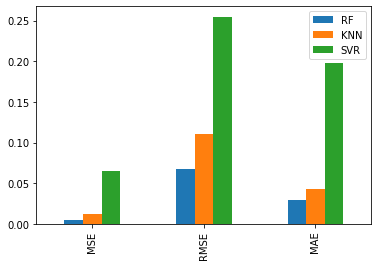

In [24]:
df_score.plot.bar()
plt.savefig(directory + '/ML_scores.png')
plt.show()

The Random Forest Regressor outpeforms the KNN Regressor and the SV Regressor for all the scores. The errors for the KNN and the SV model might be probably decreased by scaling the variables before the training step.

We proceed by computing the feature importances based on MDI and MDA. 

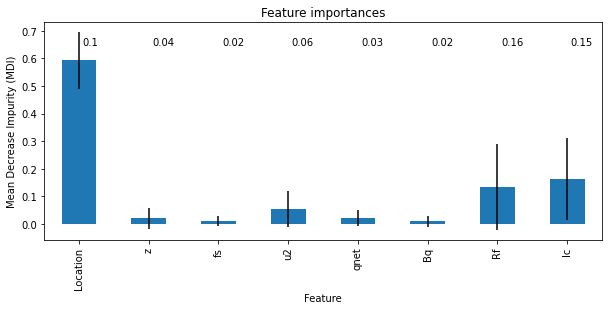

In [25]:
#rf = grid_rf.best_estimator_   uncomment if using GridSearchCV
featureImp= []
for feat, importance in zip(X_train.columns, rf.feature_importances_):  
    temp = [feat, importance]
    featureImp.append(temp)

ft_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
ft_df.set_index('Feature',inplace=True)

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
ft_df.plot.bar(yerr=std,figsize = (10,4),legend=None)

for i in range(len(std)):
    plt.text(0.05 + i,0.65,round(std[i],2))
plt.title("Feature importances")
plt.ylabel("Mean Decrease Impurity (MDI)")
plt.savefig(directory + '/feature_importance_MDI.png')
plt.show()

We see that the most important features are *lc*, *Rf*, *lc*, and *u2*. The bar plot shows that the standard deviations are in general quite large. We conclude that *Location*, *Rf*, *lc*, and *u2* are inidicative of the presence of a problematic material, but we cannot be confident about the importance except for *Location*.

We now compute the mean decrease accuracy to check whether *Location* is the most relevant feature, without accounting for the high-cardinality drawback of the mean decrease impurity.

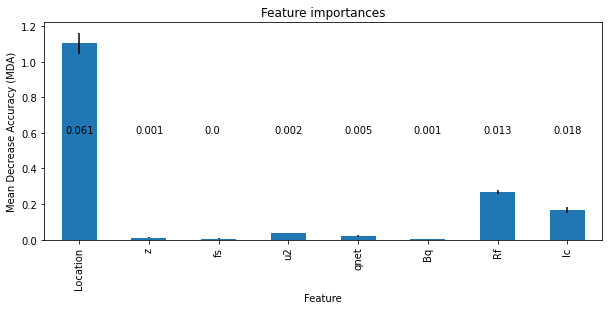

In [26]:
# returns hash-table with importances mean and std
perm_importance = permutation_importance(rf, X_train, y_train,random_state = 42) # test data yields similar result 
                                                                                 
featureImp= []
for feat, importance in zip(X_train.columns, perm_importance.importances_mean):  
    temp = [feat, importance]
    featureImp.append(temp)

ft_df2 = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
ft_df2.set_index('Feature',inplace=True)
std2 = perm_importance.importances_std
ft_df2.plot.bar(yerr=std2,figsize = (10,4),legend = None)

for i in range(len(std2)):
    plt.text(i-0.2,0.60,round(std2[i],3))
plt.title("Feature importances")
plt.ylabel("Mean Decrease Accuracy (MDA)")
plt.savefig(directory + '/feature_importance_MDA.png')
plt.show()

### Estimate confidence interval of predicted probabilities by Bagging property

The Bagging property of the trained Random Forest allows us to compute the mean and standard deviation (std) for the umarked entries by taking the output of all the trees. However, we show that the result is not satisfactory at all, as in most cases the std is even higher than the mean value.

In [27]:
X_0 =  df[cond_0].values[:,:-1] # take data from first DataFrame, with cond_0 for categorical class '-' 
preds = np.stack([tree.predict(X_0) for tree in rf.estimators_]) 
std_0 = np.std(preds,axis=0)
mean_0 = np.mean(preds,axis=0)

df_pred = pd.DataFrame({'mean':mean_0,'std':std_0})

In [28]:
print('There are in total {} values with std greater than mean'.format(len(df_pred[df_pred['std']/df_pred['mean'] > 1.0])))

There are in total 9583 values with std greater than mean


## Probability estimation for unmarked data

We have realized that the probability computed by the Random Forest Regressor is affected by high variance. However, we know that *Location* is the most important feature to predict the probability of proximity to the problematic material in the training set. 

We will check per location what is the proportion of marked and unmarked entries. We expect an evident imbalance of 'y' and 'n' marks, so that we can predict for '-' entries with the trained Random Forest per cluster, assuming that the predicted values are similar to each other.

In [29]:
# By default for each key there is a list object as value
from collections import defaultdict

In [30]:
df_loc = df2.groupby(['Location'])[['Near_Material']]
n_clusters = len(df_loc)

dict_marks = defaultdict(list)

for i in range(1,n_clusters+1):
    
    # get total number of entries ('y','n', and '-' in the original DataFrame)
    entries = df_loc.get_group(i)['Near_Material'].value_counts().sum()
    
    try:
        # take number of entries with value >= 0.9 ('y' entries)
        y = (df_loc.get_group(i).values >= 0.9).sum()
    except:
        y = 0
    
    try:  
        # take number of entries with value 0.0  ('n' entries)
        n = (df_loc.get_group(i).values == 0.0).sum()
    except:
        n = 0
    
    dict_marks['y'].append(y)
    dict_marks['n'].append(n)
    dict_marks['ratio marked/entries'].append(round((y+n)/entries*100,3))
    
    print(f'Location {i}: y={y}, n={n} out of {entries} entries')

df_marks = pd.DataFrame(dict_marks)
df_marks.index = list(np.arange(1,n_clusters+1))

Location 1: y=0, n=32 out of 3144 entries
Location 2: y=0, n=1 out of 1566 entries
Location 3: y=0, n=20 out of 1859 entries
Location 4: y=0, n=17 out of 3173 entries
Location 5: y=0, n=1 out of 1404 entries
Location 6: y=0, n=17 out of 1438 entries
Location 7: y=0, n=26 out of 938 entries
Location 8: y=21, n=0 out of 1470 entries
Location 9: y=21, n=0 out of 3109 entries
Location 10: y=3, n=0 out of 2980 entries
Location 11: y=0, n=1 out of 385 entries
Location 12: y=12, n=12 out of 3025 entries
Location 13: y=0, n=3 out of 1411 entries
Location 14: y=6, n=15 out of 1822 entries
Location 15: y=39, n=11 out of 1757 entries
Location 16: y=25, n=0 out of 2995 entries
Location 17: y=2, n=0 out of 1796 entries
Location 18: y=21, n=0 out of 433 entries


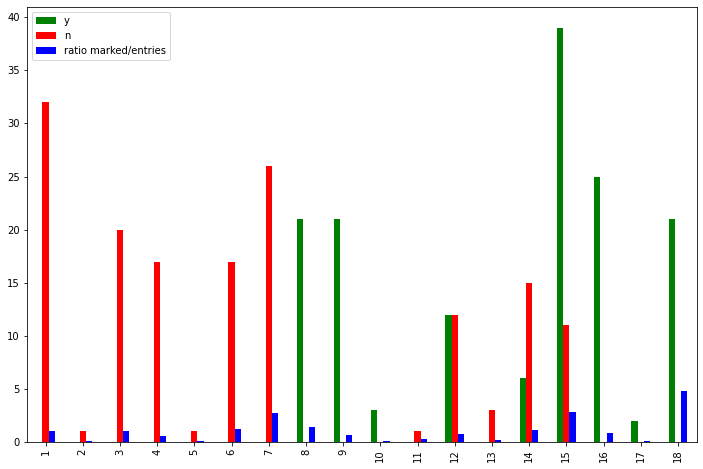

In [31]:
df_marks.plot.bar(figsize = (12,8),color={"y": "green", "n": "red", 'ratio marked/entries': "blue"})
plt.savefig(directory + '/marks_per_Location.png')
plt.show()

Since there is a clear difference between 'y' and 'n' entries in almost every cluster (except for 12 and 14), we decide to compute the confidence intervals for each cluster in the next Section.

## Confidence Interval

Confidence intervals provide a likelihood that the model outcome will fall between a computed range when making predictions on new data. A robust way to calculate confidence intervals for machine learning algorithms is to use the **Bootstrap algorithm**. This is a general technique that can be used to calculate empirical confidence intervals, regardless of the data distribution.


The main strategy consists of:

- Fix a total number of iterations.


- At each iteration, sample with replacement 50% up to 80% of the test data (for large dataset).


- Predict the outcome of the sampled data with any machine learning model trained previously.


- At the end of each iteration, compute the mean value of the outcomes. 


- At the end of the iterations, compute the desired empirical percentile given the list of the mean values.

We are left with only one problem. If we want to estimate the confidence interval for each unmarked data, we need to repeat all the previous steps for more than 34000 entries. This is very time consuming unless parallel computing is exploited. 

We overcome this issue by exploiting the previous clusters based on *Location*, as it is the feature that most discriminates the marked entries. Furthermore, the low correlation with *Rf* (see Heatmap) can further help estimate the probability. Eventually, we compute the confidence interval for each cluster. 

We avoid clustering the data using any unsupervised machine learning method, as we already know from the feature importances that *Location* and *Rf* are the most discriminative ones. Moreover, we cannot assume that similar features found by a clustering algorithm, as K-means, can help discriminate the two marked classes within each group.

### Run Bootstrap algorithm

We will use 1000 bootstrap iterations and select a sample with replacement that is 50% the size of the entire cluster. We will compute the intervals with 90% confidence level.

In [32]:
from sklearn.utils import resample

def prob_estimation(df):
    probs = []
    n_iterations = 1000
    n_size = int(len(df)*0.50)
    idxs = list(df.index)
    for i in range(n_iterations):
        # prepare train and test sets
        test = resample(df, n_samples=n_size)
        # evaluate model
        pred = rf.predict(test.values[:,:-1])
        probs.append(pred.mean())
    return probs

Location 1: median = 0.0009 with 5th percentile = 0.0007 and 95th percentile = 0.0011
Location 2: median = 0.0003 with 5th percentile = 0.0001 and 95th percentile = 0.0004
Location 3: median = 0.0004 with 5th percentile = 0.0003 and 95th percentile = 0.0006
Location 4: median = 0.0005 with 5th percentile = 0.0003 and 95th percentile = 0.0006
Location 5: median = 0.0001 with 5th percentile = 0.0000 and 95th percentile = 0.0002
Location 6: median = 0.0005 with 5th percentile = 0.0003 and 95th percentile = 0.0006
Location 7: median = 0.0003 with 5th percentile = 0.0000 and 95th percentile = 0.0006
Location 8: median = 0.4740 with 5th percentile = 0.4547 and 95th percentile = 0.4947
Location 9: median = 0.5920 with 5th percentile = 0.5783 and 95th percentile = 0.6059
Location 10: median = 0.5035 with 5th percentile = 0.4899 and 95th percentile = 0.5175
Location 11: median = 0.1026 with 5th percentile = 0.0838 and 95th percentile = 0.1218
Location 12: median = 0.5619 with 5th percentile = 0

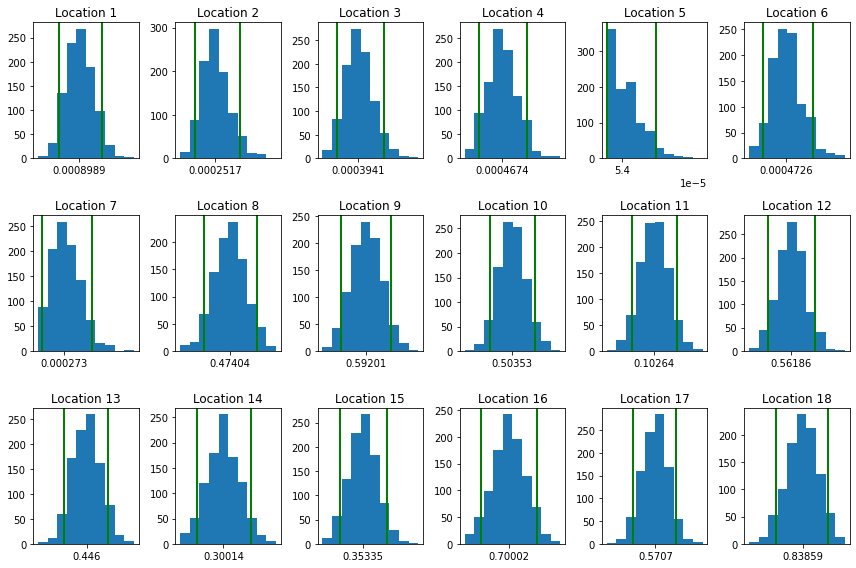

In [33]:
plt.figure(figsize = (12,8))

n_clusters = 18
for i in range(1,n_clusters+1):
    cond_loc = df2['Location'] == i
    probs = prob_estimation(df2[(cond_loc) & (cond_0)])  # estimate probability of cluster i for unmarked data 
                                                         # cond_0 selects only unmarked data with value -1.0
                                                         # check with df2[cond_0]['Near_Material'].value_counts()
    
    # confidence intervals with 90% confidence level
    alpha = 0.9
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(probs, p))  # p must be between 0 and 100
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(probs, p))
    median = np.median(probs)
    
    
    # plot probs
    plt.subplot(3,6,i)
    plt.hist(probs)
    plt.xticks([median])
    plt.title(f'Location {i}')
    plt.axvline(x=lower, color='g', linestyle='-',linewidth = 2)
    plt.axvline(x=upper, color='g', linestyle='-',linewidth = 2)
    print('Location %.1d: median = %.4f with 5th percentile = %.4f and 95th percentile = %.4f' % (i,median, lower, upper))
    plt.tight_layout()

plt.savefig(directory + '/CI_Locations')
plt.show()

As observed in the previous plot, clusters from 1 to 7 contain only 'n' entries. The result of the Bootstrap algorithm align with this information as the probabilities are very close to 0. Concerning cluster 8 and 10, we would have expected a value exceeding 0.5, but probably other features, such as *Rf*, have constrained the probability slightly below the threshold. Finally, clusters 16, 17 and 18 yield the highest probability. This agrees again with the previous plot, which shows only 'y' entries in those groups. 

**Therefore, we conclude that the Location keys where it is more likely to find samples with problematic material, considering both marked and unmarked entries, are 9, 12, 16, 17 and 18.**

## Conclusions

In this work, we have analysed the dataset of cone-penetrometer testing (CPT) data. Our goal was to establish whether unmarked ('-') entries were close to a sample of problematic material or not. We were provided with some marked entries containing a sample ('y') or not ('n'). 

We summarize here the methodology adopted, our findings and the main results.

We highlight that one of the main challenges of this task was the huge imbalance of test (unmarked) and training (marked) data. 

Firstly, we conducted an exploratory data analysis (EDA). We observed that **unmarked entries contain outliers for *qc*, *qnet*, *Rf*, *lc*, *Bq*, and *u2***. Another finding in the EDA is the **perfect linear relatioship** between *qc* and *qnet*, which suggests a deterministic dependence. We also remind that a small proportion of the data had missing entries, which have been imputed by taking the mean for each feature per class, without considering the outliers detected previously.

Since it is not guaranteed that the marked rows contain the problematic material (although the probability is quite high), **we have converted the classes from categorical to numerical**. We accounted for this fact by sampling uniformly at random values in the range [0.9,1] for 'y' entries, whereas 'n' entries have been encoded into 0.

Given all the premises about the dataset, we have decided to train a Random Forest Regressor to estimate the probability that each unmarked data is close the problematic material. This method trains different Regression Trees and allows to compute feature importances. We have compared this method with other two machine learning models (KNN Regressor and SV Regressor) and noticed the **Random Forest outperforms the other models in terms of all the performance metrics**.


Another useful characteristic of the Random Forest is the ability to compute the feature importances by exploiting the Bagging property. We have realized that ***Location* is the most important feature with small standard deviation**, followed by *Rf*, and *lc*.


The next challenge we addressed was the evaluation of confidence intervals. By taking the mean and standard deviation (std) of the predicted values returned by the Random Forest, we have observed a very poor performance, as about 10000 entries display std higher than the mean. We have opted for another method to compute confidence intervals: the **Bootstrap algorithm**. However, this procedure should be applied to each unmarked entry, which is very time consuming for real case studies where the relative size is huge.

We have overcomed this problem by grouping the data by Location. Since we know that this is the most discriminative feature of the Random Forest, we have predicted for each cluster the average probability of proximity to the material with 90% confidence level. The results are promising, since for almost all clusters the median of the distribution is far from the 0.5 threshold within narrow lower and upper percentiles. 

Despite the big limitations in the available marked data, we have been able to train a Random Forest Regressor and cluster the entries based on the *Location* feature to compute the average probability and confidence intervals.


In conclusion, we propose suggestions to conduct a more accurate and in-depth analysis: 

- Information about Location: if this feature is provided with latitude and longitude values, it would be possible to compute the distance between marked and unmarked data. This would replace the *Location* categorical feature and improve the performance of any machine learning model.


- Information about outliers for specific features: it would be beneficial to understand the reason why unmarked data have some many outliers for *Rf* and *qc* measurements. If those values are not due to measurement errors, we should handle them profitably with the advice of domain knowledge experts.


- Information about the problematic material: knowledge about the nature of this material and its geospatial distribution can be coupled with the available dataset to improve significantly the prediction of the unmarked entries.


- Balanced dataset: we don't know why marked and unmarked data are highly imbalanced, but we assume that it is unfeasible to collect more marked data easily. It would be still helpful to collect few marked data but spread uniformly over the different *Location* spots, as we have noticed that the ratio between unmarked and marked data differs significantly based on that feature.


- Confidence for 'y' marks: the likelihood that an entry with 'y' mark might not contain a sample with problematic material is not specified. A possible idea to define more accurately the probability is to analyse some samples by location and assess the proportion of true 'y' entries. Also, it would be interesting to evaluate the impact of different probability ranges for 'y' entries on the performance of the Random Forest model.  